In [25]:
import numpy as np  
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

from collections import deque

from typing import Any , Literal
import warnings
warnings.filterwarnings(action = 'ignore' , category = DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Set Seaborn style
sns.set_style("darkgrid")

In [26]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.soo.nonconvex.pso import PSO

from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions


from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling

from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.operators.selection.tournament import TournamentSelection 

In [28]:
def initialize_population(population_size, num_variables, num_ojective):
    problem = Problem(n_var = num_variables, n_obj = num_ojective ,  xl=0, xu=1)
    sampling = FloatRandomSampling()
    X = sampling(problem, population_size).get("X")
    return X


Xg_ = initialize_population(100, 10, 3)
Xg_1 = initialize_population(100, 10, 3)


In [29]:
def binary_tournament(pop, P, **kwargs):
    # The P input defines the tournaments and competitors
    n_tournaments, n_competitors = P.shape

    if n_competitors != 2:
        raise Exception("Only pressure=2 allowed for binary tournament!")

    # the result this function returns

    S = np.full(n_tournaments, -1, dtype=np.int)

    # now do all the tournaments
    for i in range(n_tournaments):
        a, b = P[i]

        # if the first individual is better, choose it
        if pop[a].F < pop[b].F:
            S[i] = a

        # otherwise take the other individual
        else:
            S[i] = b

    return S

def tradition_EA(name , population, cross_over_rate, mutation_over_rate ):
    ref_point = 1 if name == 'ackley' else 3
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", ref_point, n_partitions=population.shape[0])
    # create the algorithm object
    algorithm = PSO(pop_size=None,
                    ref_dirs=ref_dirs,
                    sampling = population,
                    selection=TournamentSelection(func_comp=binary_tournament),
                     crossover=SBX( eta= 1 , prob= cross_over_rate ),
                     mutation=PM(eta=1, prob= mutation_over_rate ),)
    # execute the optimization
    problem = get_problem("ackley", n_var=population.shape[1], a=20, b=1/5, c=2 * np.pi) if name == "ackley" else get_problem(name, n_var=population.shape[1])

    res = minimize(problem,
                algorithm,
                seed=1,
                termination=('n_gen', 1))
    return res.X

In [30]:
class learning_aided_evolution:
    def __init__(self,
                problem: Literal["dtlz1", "dtlz2", "dtlz3", "dtlz4",
                                "dtlz5", "dtlz6", "dtlz7", "ackley"] = "dtlz1",
                arch_size: int = 100,
                cross_over_rate: float = .5,
                mutation_rate: float = .9,
                n_obj: int = 3) -> None:
        self.problem = problem
        self.arch_size = arch_size
        self.cross_over_rate = cross_over_rate
        self.mutation_rate = mutation_rate
        self.n_obj = n_obj
        self.k = 1

        if problem in [ "dtlz2", "dtlz3", "dtlz4", "dtlz5", "dtlz6", "dtlz7", 'ackley' ]:
            self.n_var = 10
        elif problem in ['dtlz1']:
            self.n_var = 7
        else:
            raise Exception ("bad problem name")
    
    def cross_over(self, X_A, X_B, cross_over_rate):
        if np.random.rand() <= cross_over_rate:
            return X_A
        else:
            return X_B
        
    def mutation(self, X_A, X_B,X_C, ):
        """
        XA + cross_over_rate * (XB - Xc)
        """
        return X_A + self.mutation_rate * (X_B - X_C)

    def uniform_selection(self, population, k, ):  # population is a list of individuals
        population = population.tolist() if isinstance(population, np.ndarray) else population
        # generate the random array
        # use the choice method of the Generator class
        rng = np.random.default_rng()
        A_sampled = rng.choice(population, self.k)
        return A_sampled


    def run(self , Xg, newX ):
        newX = list()
        for i in range(1, len(Xg) ):
            LC = self.cross_over(Xg[1-i] , Xg[i ], self.cross_over_rate)
            newX.append(LC)

        for i in range(2, len(Xg) ):
            LM = self.mutation( Xg[i - 2], Xg[i - 1], Xg[i],)
            newX.append(LM)
        
        selection = self.uniform_selection( newX, self.k )
        return selection[-1] if self.problem == 'ackley' else selection


In [31]:
# initialize_ANN
def initialize_ANN(n_var, lr = 0.1 , active_function = 'softmax'):
# Create the modelweights_randomly
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = n_var,
                              name = "Input"),
        tf.keras.layers.Dense(n_var * 3,
                              activation = 'sigmoid',
                              name = "hidden"),
        tf.keras.layers.Dense(n_var ,
                              activation = active_function,
                              name = "Output")
    ])

    model.compile(optimizer=Adam(lr), loss='mse')
    return model

In [32]:
# train_ANN
def train_ANN(model, X_train, y_train) -> np.ndarray:
    hist = model.fit(X_train, y_train, epochs=1, verbose=False)
    ypred = model.predict(X_train, verbose=False)
    return model, ypred[0] , hist.history['loss']


In [33]:
def MSE(arch_size, Lx, X):
    # Lx = np.argmax(Lx, axis=1)
    summ = np.sum(np.abs(Lx - X) ** 2)
    return (1/arch_size) * summ

In [34]:
def ackley(x, *args):
    x = np.asarray_chkfinite(x) 
    n = len(x)
    
    first_sum = 0.0
    second_sum = 0.0
    for c in x:
        first_sum += c**2.0  
        second_sum += np.cos(2.0*np.pi*c)

    return -20.0*np.exp(-0.2*np.sqrt(first_sum/n)) - np.exp(second_sum/n) + 20 + np.e



def dtlz1(x, n_obj, k=5):
    # x.reshape(1,1)
    # print(x.shape())
    g = 100*(k+np.sum((x[:,(n_obj-k):]-0.5)**2, axis=1))
    f = [0.5*np.prod(x[:,0:(n_obj-k)], axis=1)*(1 + g)]
    for i in range(n_obj-k-1):
        f.append(0.5*np.prod(x[:,0:(n_obj-k-i)], axis=1)*(1 - x[:,(n_obj-k-i-1)]*(1 + g))) 
    f.append(0.5*(1 - x[:,0])*(1 + g))
    return np.array(f).T


def dtlz2(x, n_obj, k=10):
    g = np.sum((x[:,(n_obj-k):]**2), axis=1)
    f = [np.prod(np.cos(x[:,0:(n_obj-k)]*np.pi/2), axis=1)*(1 + g)]
    for i in range(n_obj-k-1):
        f.append(np.prod(np.cos(x[:,0:(n_obj-k-i)]*np.pi/2), axis=1)*(1 + g))
    f.append((1 + g)*np.sin(x[:,0]*np.pi/2))
    return np.array(f).T

def dtlz3(x, n_obj, k=10):
    g = 100*(k+np.sum((x[:,(n_obj-k):]-0.5)**2, axis=1))  
    f = [np.prod(x[:,0:(n_obj-k)], axis=1)*(1 + g)]
    for i in range(n_obj-k-1):
        f.append(np.prod(x[:,0:(n_obj-k-i)], axis=1)*(1 + g)) 
    f.append((1 + g)*np.sin(x[:,0]*np.pi/2))
    return np.array(f).T
    
def dtlz4(x, n_obj, alpha=100):
    g = np.sum((x[:,(n_obj-1):]**2), axis=1)
    f = [np.prod(np.cos(x[:,0:(n_obj-1)]**alpha * np.pi/2), axis=1)*(1 + g)]
    for i in range(n_obj-2):
        f.append(np.prod(np.cos(x[:,0:(n_obj-2-i)]**alpha * np.pi/2), axis=1)*(1 + g)) 
    f.append(np.sin(x[:,0]**alpha * np.pi/2))
    return np.array(f).T


def dtlz5(x, n_obj, g=None):
    if g is None:
        g = np.sum((x[:,(n_obj-1):]-0.5)**2, axis=1)        
    theta = x[:,0:(n_obj-1)]*np.pi/2
    f = [np.prod(np.cos(theta), axis=1)]
    for i in range(n_obj-2):
        f.append(np.prod(np.cos(theta[:,0:(n_obj-2-i)]), axis=1)) 
    f.append(np.sin(theta[:,0]))
    f = np.array(f).T
    return (1 + g.reshape(-1,1))*f

def dtlz6(x, n_obj, alpha=100):
    g = np.sum(x[:,(n_obj-1):]**alpha, axis=1) 
    theta = x[:,0:(n_obj-1)]*np.pi/2
    f = [np.prod(np.cos(theta), axis=1)]
    for i in range(n_obj-2):
        f.append(np.prod(np.cos(theta[:,0:(n_obj-2-i)]), axis=1))
    f.append(np.sin(theta[:,0])) 
    f = np.array(f).T
    return (1 + g.reshape(-1,1))*f
    
def dtlz7(x, n_obj, g=None):
    if g is None:
        g = 1 + 9*np.mean(x[:,(n_obj-1):], axis=1) 
    f = [x[:,0]]
    for i in range(n_obj-2):
        f.append(x[:,i+1])
    f.append((1 + g)* (n_obj - np.sum(x[:,0:(n_obj-1)], axis=1)/(n_obj-1))) 
    return np.array(f).T

In [35]:
def fitness(name : str, 
            indivisual: np.ndarray , 
            n_objective: int) -> float| np.ndarray:
    match name:
        case "dtlz1":
            return dtlz1( indivisual , n_objective)
        case "dtlz2":
            return dtlz2( indivisual , n_objective)
        case "dtlz3":
            return dtlz3( indivisual , n_objective)
        case "dtlz4":
            return dtlz4( indivisual , n_objective)
        case "dtlz5":
            return dtlz5( indivisual , n_objective)
        case "dtlz6":
            return dtlz6( indivisual , n_objective)
        case "dtlz7":
            return dtlz7( indivisual, n_objective)
        case "ackley":
            return ackley( indivisual , n_objective)
        case _ :
            raise ValueError("bad arg")
        
        
def time_fitness(function, *args, **kwargs):
  start_time = time.time()
  LX = function(*args, **kwargs)
  end_time = time.time()
  time_delay = (end_time - start_time) / 1000 
  return time_delay , LX

In [36]:
def is_better(problem : str,
                individual_1 : np.ndarray,
                individual_2 : np.ndarray,
                n_objective : int) -> tuple[bool, np.ndarray]:
    
    fitness_individual_1 = fitness( problem, 
                                    individual_1,
                                    n_objective)
    
    fitness_individual_2 = fitness( problem, 
                                    individual_2,
                                    n_objective)

    if np.any(fitness_individual_1 < fitness_individual_2):
        
        return True , individual_1
    else:
        return False , individual_2

In [37]:
def uniform_selection( population, k, ):  # population is a list of individuals
    population = population.tolist() if isinstance(population, np.ndarray) else population
    # generate the random array
    # use the choice method of the Generator class
    rng = np.random.default_rng()
    A_sampled = rng.choice(population, k)
    return A_sampled

In [62]:
def sorting_archive(problem, archive , n_obj):
    fitness_values0 = fitness( problem,archive[0] , n_obj)
    fitness_values1 = fitness( problem,archive[1] , n_obj)
    AXIS = 0 if problem == "ackley" else 1
    sorted_indices0 = np.argsort(np.any(fitness_values0 <= fitness_values1 , axis=AXIS))
    # sorted_indices1 = np.argsort(np.any(fitness_values0 > fitness_values1 , axis=AXIS))

    archive = np.array(archive)
    sorted_fitness = archive[sorted_indices0 ]
    return sorted_fitness



def add_to_archive(archive, new_element):
    # Shift existing elements to the right (from index 9 to 1)
    archive[1:] = archive[:-1]

    # Add the new element at index 0
    archive[0] = new_element
    return archive

In [101]:
def main(
    Problem : object,
    archive_size : int,
    lp : float,
    n_generations : int,
    first_gen_size : int,
    n_obj : int,
    n_var : int,
    cross_over_rate : float,
    mutation_rate : float,
    ANN_learning_rate : float,
    ANN_Activatvation_function : Literal['sigmoid' , 'softmax'],
    plot : bool
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    


    Xg  : np.ndarray = initialize_population(first_gen_size, n_var, n_obj )  # Initialize population and evaluate fitness
    
    ANN = initialize_ANN(1 if Problem == 'ackley' else n_var , 
                         ANN_learning_rate , ANN_Activatvation_function )  # Initialize ANN weights randomly
    
    
    archive = deque(maxlen = archive_size)

    trained_solutions = deque(maxlen = archive_size)
    all_losses  = deque(maxlen = archive_size)

    leo = learning_aided_evolution(Problem, 
                                   archive_size, 
                                   cross_over_rate, 
                                   mutation_rate, 
                                   n_obj)

    for gen in range(n_generations):
        leo.k = 1 if Problem == "ackley" else Xg.shape[0]

        r = np.random.uniform(0,1)
        if gen > 1 and r < lp:
            newX = leo.run(Xg, newX)

        else :
            newX = tradition_EA(Problem, Xg, cross_over_rate, mutation_rate )


        Xg_i = uniform_selection(newX , newX.shape[0])

        # SEP Collection
        better = is_better(Problem, Xg_i, newX, n_obj)[1]
        for i, v in enumerate(better) :
            if v in Xg_i:
                newsep = np.array([Xg_i[i], newX[i]] )
                archive.append( newsep)
                
            elif v in newX:
                newsep = np.array([newX[i],  Xg_i[i]] )
                archive.append( newsep)


 
        # archive = sorting_archive(Problem, archive, n_obj)
        # archive = deque(archive)
        for x1, x2 in archive:
            ANN, traind, loss = train_ANN(ANN, x1.reshape(1,-1), x2.reshape(1,-1))
            trained_solutions.append(traind)
            all_losses.append( loss[0] )

        print(f"gen{gen+1}=", end= "")


    loss = np.sum(all_losses) / archive_size
    if plot:
        fig, ax = plt.subplots(1,3 , figsize=(15, 5))
        sns.scatterplot(Xg,            legend=False , ax=ax [0] )
        ax[0].set_xlabel('initialize population' , fontsize = 10, fontdict = {'font': 'Times new Roman'})
        ax[0].set_ylabel('f (x)', fontdict = {'font': 'Times new Roman'})

        ax[0].grid(visible =True)

        plt.title('Output of Algorithm')

        sns.scatterplot(trained_solutions, legend=False , ax=ax [1] )
        ax[1].set_xlabel('solution for Problem' , fontsize = 10, fontdict = {'font': 'Times new Roman'})
        ax[1].set_ylabel('f (x)', fontdict = {'font': 'Times new Roman'})
        ax[1].grid(visible =True)

        sns.lineplot(all_losses,    legend=False , ax=ax [2] )
        ax[2].set_xlabel('Generation' , fontsize = 10, fontdict = {'font': 'Times new Roman'})
        ax[2].set_ylabel('loss', fontdict = {'font': 'Times new Roman'})

        ax[2].grid(visible =True)
        plt.savefig(f"data-{Problem}-{n_obj}.png")
        plt.savefig(f"data-{Problem}-{n_obj}.svg")

        plt.show()
    
    return archive, np.array(trained_solutions), loss
     

In [103]:
PROBLEM =  'dtlz3'
ARCHIVE_SIZE = 100
LP = .5
N_GENERATORS = 5
FIRST_GEN_SIZE = 100
CROSS_OVER_RATE = .5
MUTATION_RATE = .9
N_OBJ = 3
N_VAR = 100
ANN_LR = .01
ANN_AC_FUNCTION = 'softmax'


gen1=gen2=gen3=gen4=gen5=

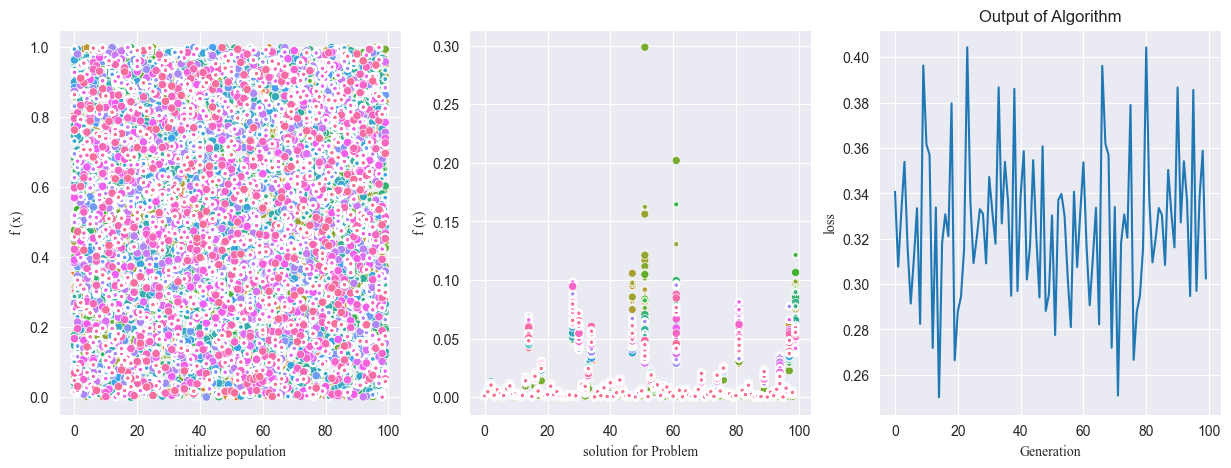

In [104]:
Archive , Solutions, loss = main(
    PROBLEM,
    archive_size = ARCHIVE_SIZE,
    lp = LP,
    n_generations = N_GENERATORS, # number of generations
    first_gen_size = FIRST_GEN_SIZE, # number of generations 
    cross_over_rate = CROSS_OVER_RATE, # cross over rate
    mutation_rate = MUTATION_RATE, # mutation rate 
    n_obj= N_OBJ, # number of observations
    n_var= N_VAR, # number of variables
    ANN_learning_rate = ANN_LR, # learning rate
    ANN_Activatvation_function= ANN_AC_FUNCTION, # activation function for ANN
    plot = True,
)

In [105]:
print(loss)
np.array(Archive).shape

0.32579964488744734


(100, 2, 100)

In [106]:
arc_1 = np.array([i for i, _ in Archive])
arc_2 = np.array([j for  _, j in Archive])

In [50]:
%matplotlib qt

In [94]:
%matplotlib inline

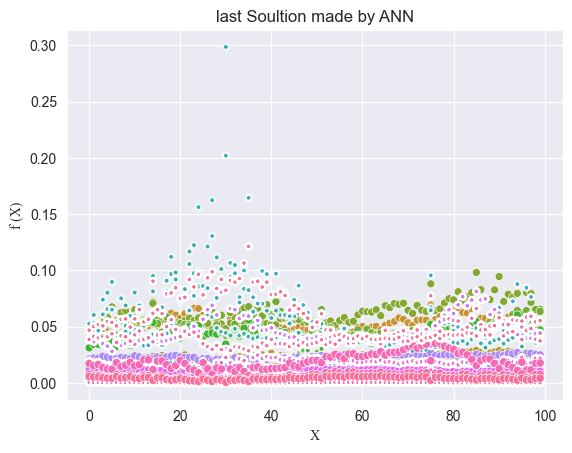

In [107]:


sns.scatterplot(Solutions
,
legend=False)

plt.title("last Soultion made by ANN")


plt.ylabel('f (X)', fontdict = {'font': 'Times new Roman'})
plt.xlabel('X', fontdict = {'font': 'Times new Roman'})

# plt.xlabel('num of Objectvies (X)')
plt.savefig("Archive.png")
plt.savefig("Solutions.svg")
plt.show()

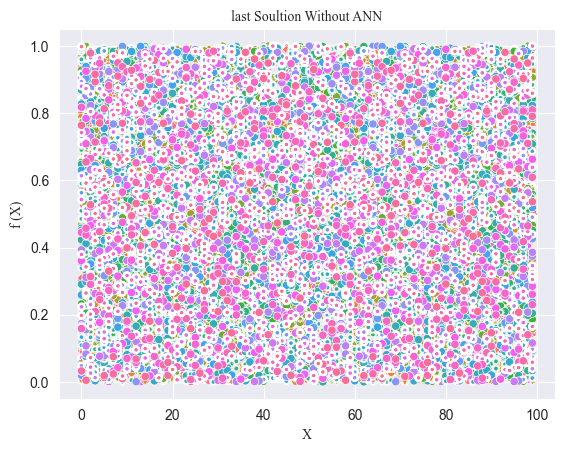

In [116]:


sns.scatterplot(np.array(Archive)[:,0]
,
legend=False)


sns.scatterplot(np.array(Archive)[:,1]
,
legend=False)
plt.title("last Soultion Without ANN", fontdict = {'font': 'Times new Roman'})


plt.ylabel('f (X)', fontdict = {'font': 'Times new Roman'})
plt.xlabel('X', fontdict = {'font': 'Times new Roman'})

# plt.xlabel('num of Objectvies (X)')
plt.savefig("Archive.png")
plt.savefig("Solutions.svg")
plt.show()

In [117]:

pd.DataFrame( arc_1,
              ).to_excel("Archive 1.xlsx")

pd.DataFrame( arc_2,
              ).to_excel("Archive 2.xlsx")

pd.DataFrame(
    Solutions 
).to_excel("ANN sulotion.xlsx")

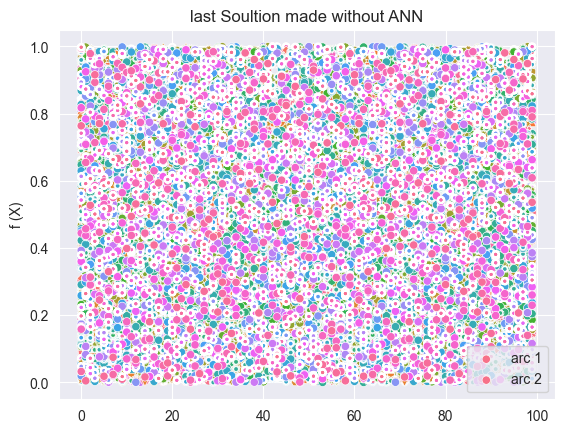

In [118]:
sns.scatterplot(arc_1
, legend=False)

sns.scatterplot(arc_2
, legend=False)
plt.title("last Soultion made without ANN")
plt.ylabel('f (X)')
# plt.xlabel('num of Objectvies (X)')
plt.savefig("Archive.png")
plt.savefig("Archive.svg")
plt.legend(['arc 1', 'arc 2'])
plt.grid(visible=True)
plt.show()

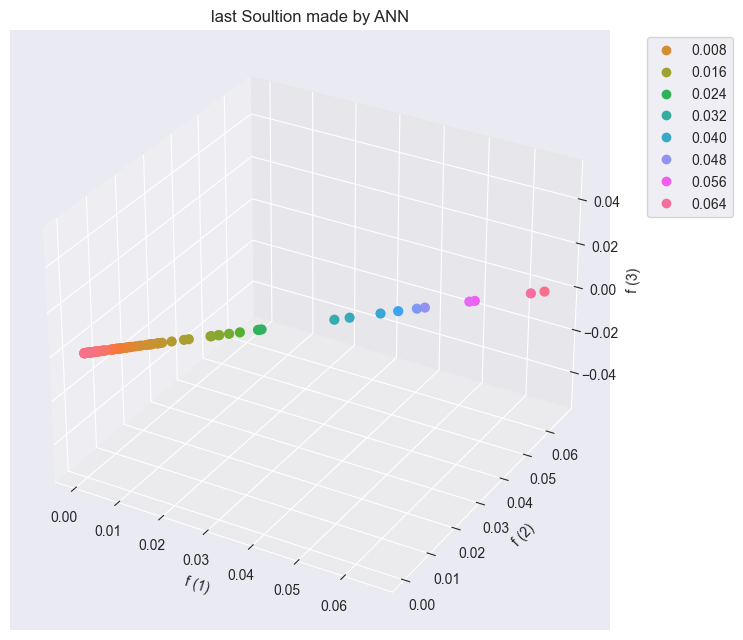

In [119]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter3D(Solutions[-1,:], 
                  Solutions[-1,:],
                #   Solutions[-1,:],
              c = Solutions[-1,:], 
                   s = 40, 
                   marker = 'o', 
                   cmap = cmap , 
                   alpha = 1)

plt.title("last Soultion made by ANN")
ax.set_xlabel('f (1)')
ax.set_ylabel('f (2)')
ax.set_zlabel('f (3)')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


In [58]:


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter(arc_1, 
                arc_2,
                # arc_1,
            c = arc_1, s=40, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('f (1)')
ax.set_ylabel('f (2)')
ax.set_zlabel('f (3)')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


In [ ]:
import scipy.stats as stats

arc_solution = pd.DataFrame({
    'solution' : Solutions[-2:].reshape(-1),
    "archive 1" :np.array(Archive).reshape(-1),
    # 'Archive 2' : Archive[-1,-1,:]
})

# One-sided test (alternative hypothesis: sample1 > sample2)
statistic, pvalue_greater = stats.wilcoxon(Solutions, 
                                    alternative='greater')
print("One-sided p-value:", pvalue_greater)

# Two-sided test (alternative hypothesis: not equal medians)
statistic, pvalue_two_sided = stats.wilcoxon(Solutions, 
                                   alternative='two-sided')
print("Two-sided p-value:", pvalue_two_sided)

In [90]:
# Perform Kruskal-Wallis test
import scipy.stats as stats

group1 = Solutions[-2:].reshape(-1)
group2 = np.array(Archive).reshape(-1)
group3 = np.array(Archive).reshape(-1)

k_stat, p = stats.kruskal(group1, group2, group3
                          )

print(f"""
kstat   => {k_stat :.2f} 
p value => {p :.2f}
""")


kstat   => 0.10 
p value => 0.95



In [ ]:
# Only proceed to Cohon test if Kruskal-Wallis test is significant 
if p < 0.05:
    # Extract sum of ranks of each group
    n1 = len(group1)
    sum_rank1 = stats.rankdata(group1).sum()
    
    n2 = len(group2)
    sum_rank2 = stats.rankdata(group2).sum()

    n3 = len(group3) 
    sum_rank3 = stats.rankdata(group3).sum()

    # Compare sum of ranks between pairs using z statistic 
    z_12 = (sum_rank1 - sum_rank2)/np.sqrt(n1*n2*(n1+n2+1)/12)
    z_13 = (sum_rank1 - sum_rank3)/np.sqrt(n1*n3*(n1+n3+1)/12)
    z_23 = (sum_rank2 - sum_rank3)/np.sqrt(n2*n3*(n2+n3+1)/12)
    
    # Compare to critical value
    crit = 1.96
    p_12 = 2 * (1 - stats.norm.cdf(abs(z_12))) 
    p_13 = 2 * (1 - stats.norm.cdf(abs(z_13)))
    p_23 = 2 * (1 - stats.norm.cdf(abs(z_23)))

    # Print significant results
    print(p_12, p_13, p_23)

In [ ]:
import pandas as pd
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi



# Perform the Friedman test
friedman_result = friedmanchisquare(
                                    Solutions[-1,:],
                                    arc_1[-1], 
                                    arc_2[-1], 
                                    # df['solution'].to_numpy(),
                                    # df['Archive 1'].to_numpy(),
                                    # df['Archive 2'].to_numpy()

                                    )
print(friedman_result.pvalue)
# If significant, proceed with post-hoc analysis
if friedman_result.pvalue < 0.05:
    posthoc_result = posthoc_nemenyi(Solutions)
    print(posthoc_result)
    posthoc_result.to_excel('posthoc_result.xlsx',)
    
else:
    print("No significant differences detected.")

